# Event-Related Potential


I will be analyzing and manipulating a data set of 1s scalp EEGs sampled at 500 Hz during 1000 trials of two different stimuli with the goal of gaining a better understanding of event-related potential.

##### Necessary Libraries:

In [3]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import *
rcParams['figure.figsize'] = (12,4)

### Background on EEGs:

EEGs analyze neural voltage activity using electrodes placed uniformly around the scalp. Although there are benefits to using EEGs as opposed to other methods of neural analysis such as its non-invasiveness and high temporal resolution, it also comes with its disadvantages including poor spatial resolution and high sensitivity to noise. That being said, the EEG can still provide valuable insight into the inner workings of the brain. 

### The Experiment:

Subjects are placed in a dark, electrically isolated room and EEG electrodes with a sampling rate of 500 Hz are placed on their scalp. The subject is asked to wear headphones and every few seconds, they are presented with one of two stimuli: a high pitch tone or a low pitch tone.

The data includes 1000 trials of the high pitch tone and 1000 trials of the low pitch tone both collected from a single electrode. 

### Visualizing the Data:

In [4]:
data = loadmat('data/02_EEG-1.mat') #contains EEG data for both stimuli
EEGa = data['EEGa'] #high-pitch stimulus EEG data
EEGb = data['EEGb'] #low-pitch stimulus EEG data
t = data['t'][0] #t is a [500,] vector containing the corresponding time intervals for EEGs

Both EEGa and EEGb are numpy arrays of dimension (1000, 500). One full row of each array would barely even fit on a computer screen. Therefore, the most accurate and useful way to represent this data is through a plot.

In [5]:
def label_plot(title_string="Title"):
    """
    This function labels the x-axis of a graph as Time [s], and the y-axis as Voltage $\mu V$. 
    Args:
        title_string: Desired title for graph.
    """
    plt.xlabel("Time [s]")
    plt.ylabel("Voltage [$\mu V$]")
    plt.title(title_string)
    plt.autoscale(tight=True)

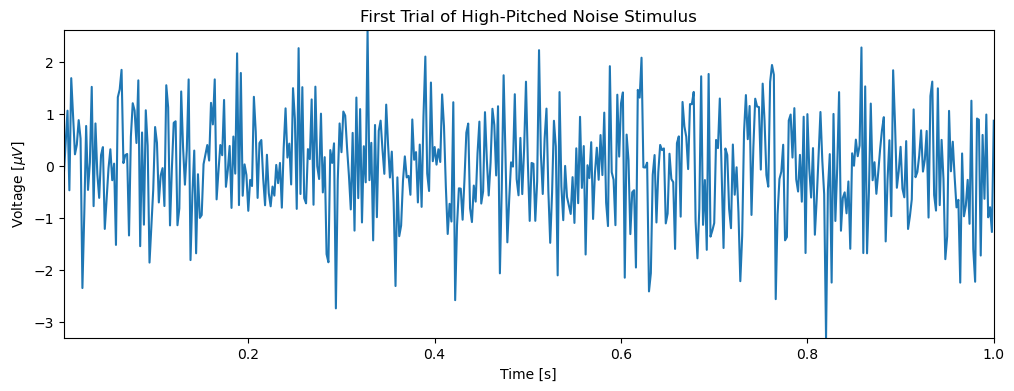

In [6]:
plt.plot(t, EEGa[0, :])
label_plot("First Trial of High-Pitched Noise Stimulus")
plt.savefig("figs/erp/eega_first_trial")
plt.show()

In the experiment, the stimulus was induced at 0.25s.

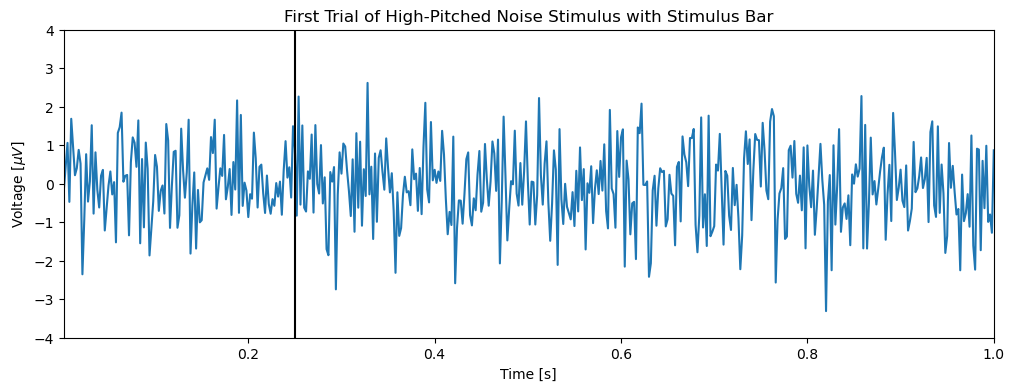

In [7]:
plt.plot(t, EEGa[0, :])
label_plot("First Trial of High-Pitched Noise Stimulus with Stimulus Bar")
plt.plot([0.25, 0.25], [-4, 4], 'k', lw=1.5) # Plots a black bar at x = 0.25.
plt.savefig("figs/erp/eega_first_trial_with_bar")
plt.show()

The above plot provides a visualization of the EEG activity before and after the high-pitched stimulus which occured at 0.25s. 

Comparing the two sets of EEG data may show observable differences between the reactions to the two stimuli.

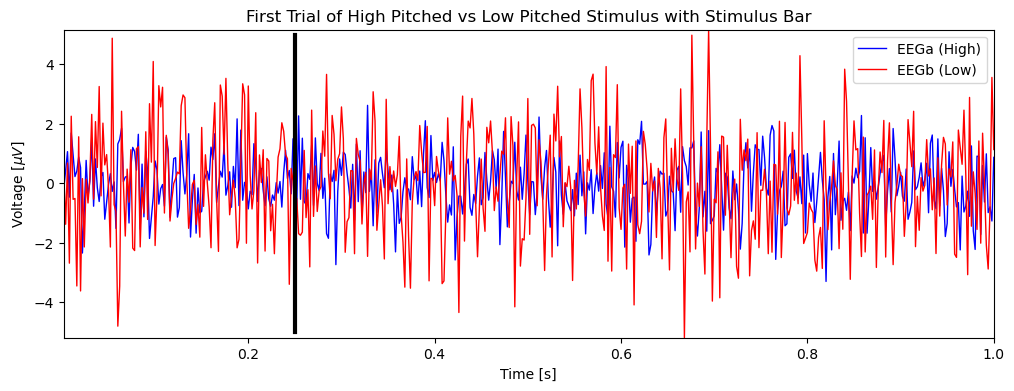

In [13]:
plt.plot(t, EEGa[0, :], 'b', label="EEGa (High)", lw=1)
plt.plot(t, EEGb[0, :], 'r', label="EEGb (Low)", lw=1)
label_plot("First Trial of High Pitched vs Low Pitched Stimulus with Stimulus Bar")
plt.plot([0.25, 0.25], [-5, 5], 'k', lw=3) #plots a black bar at x = 0.25
plt.legend()
plt.savefig("figs/erp/eega_vs_eegb_first_trial")
plt.show()

Because there are 1000 trials for each stimulus, it would be rash to make any conclusions from the comparison between each stimulus in only this one trial. Additionally, it appears that the low-pitched stimulus EEG for the first trial had a far lower signal-to-noise ratio than the high-pitched stimulus, making this plot suboptimal for comparison.

It may be more useful to plot all 1000 trials to see if patterns emerge.

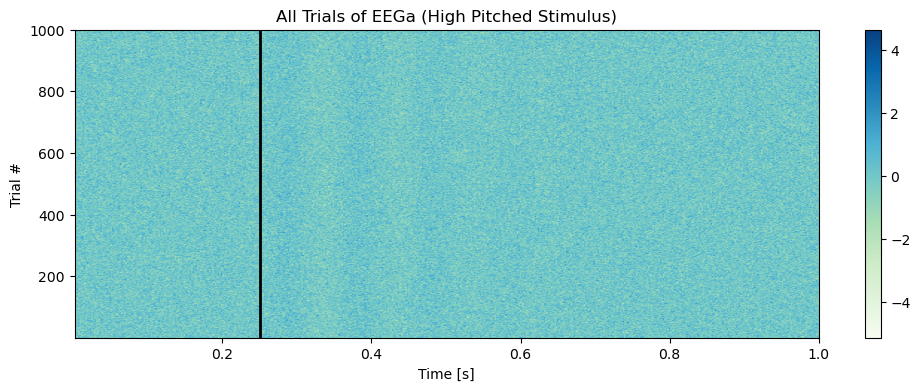

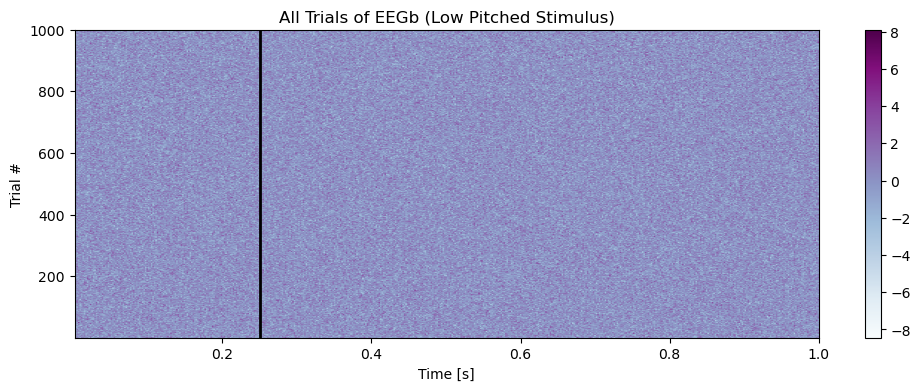

In [15]:
ntrials = len(EEGa) # Saving number of trials for continual use.
plt.imshow(EEGa, 
           cmap='GnBu', 
           extent=[t[0], t[-1], 1, ntrials], 
           aspect='auto', 
           origin='lower') # Shows the gradient of relative voltage at each position for EEGa.
plt.xlabel("Time [s]")
plt.ylabel("Trial #")
plt.title("All Trials of EEGa (High Pitched Stimulus)")
plt.colorbar()
plt.vlines(0.25, 1, 1000, 'k', lw=2)
plt.savefig("figs/erp/eega_all_trials")
plt.show()
plt.imshow(EEGb, 
           cmap='BuPu', 
           extent=[t[0], t[-1], 1, ntrials], 
           aspect='auto', 
           origin='lower') # Shows the gradient of relative voltage at each position for EEGb.
plt.xlabel("Time [s]")
plt.ylabel("Trial #")
plt.title("All Trials of EEGb (Low Pitched Stimulus)")
plt.colorbar()
plt.vlines(0.25, 1, 1000, 'k', lw=2)
plt.savefig("figs/erp/eegb_all_trials")
plt.show()

Upon close inspection, there appears to be four distinct vertical sections that are visible shortly after the stimulus is applied in EEGa. They occur at even intervals between 0.25s and ~0.5s. These sections seem to represent a fluctuating voltage directly after the stimulus is applied. We can infer then that this effect is characteristic to the EEGa dataset as a whole. There are no such visible sections for EEGb.

Although we observed some effect in the plot of EEGa (Top), these plots do not allow for a ***conclusive*** insight into the effect of the stimuli due to the significant amount of noise (non-stimulus induced voltage changes) in the EEG recordings. 

We would like to filter out this noise to isolate the voltage change caused solely by the applied stimulus, hereon referred to as the **Event Related Potential (ERP)**. As Dr. Hans Berger found in 1924, even resting state subjects exhibit rhythmic activity (the alpha rhythm), therefore we can expect that the recordings acquired in this experiment, where there are exclusively non-resting state subjects, will have ***even more*** noise than that shown in the alpha rhythm. 

Averaging out all trials will hopefully eliminate the noise and allow for only the ERP to be displayed.

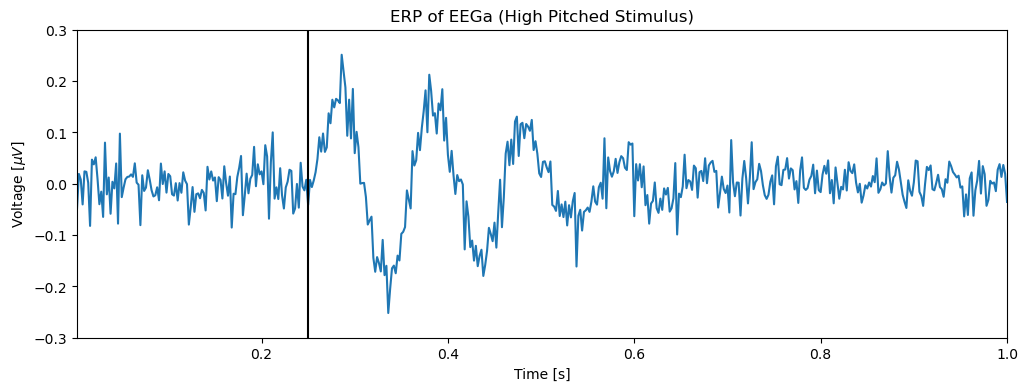

In [17]:
plt.plot(t, EEGa.mean(axis=0)) # Plots the average EEGa value per-timestep over 1 second.
label_plot("ERP of EEGa (High Pitched Stimulus)")
plt.savefig("figs/erp/erp_eega")
plt.plot([0.25, 0.25], [-0.3, 0.3], 'k', lw=1.5)
plt.show()

The displayed ERP is an average of the EEG data across all 1000 trials, however to test how accurate this average is, we must find a confidence interval for the ERP.

In [18]:
def ERP(data):
    """
    Calculates Event Related Potential and a 95% confidence interval for calculated ERP given an EEG dataset.

    Args:
        data: ndarray containing EEG dataset.

    Returns:
        (ERP of EEG dataset, Upper confidence bound, Lower confidence bound)
    """
    ntrials = len(data)
    ERP = data.mean(axis=0)
    std = data.std(axis=0)
    stdmn = std / np.sqrt(ntrials)
    conf_h = ERP + stdmn * 2
    conf_l = ERP - stdmn * 2
    
    return ERP, conf_h, conf_l

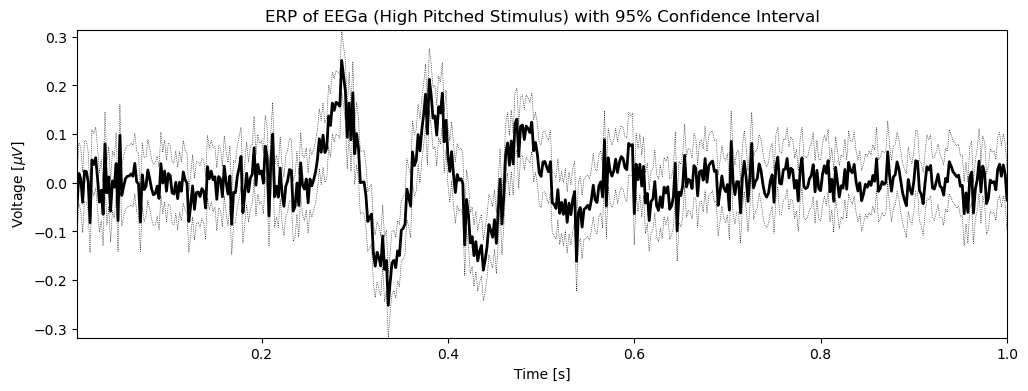

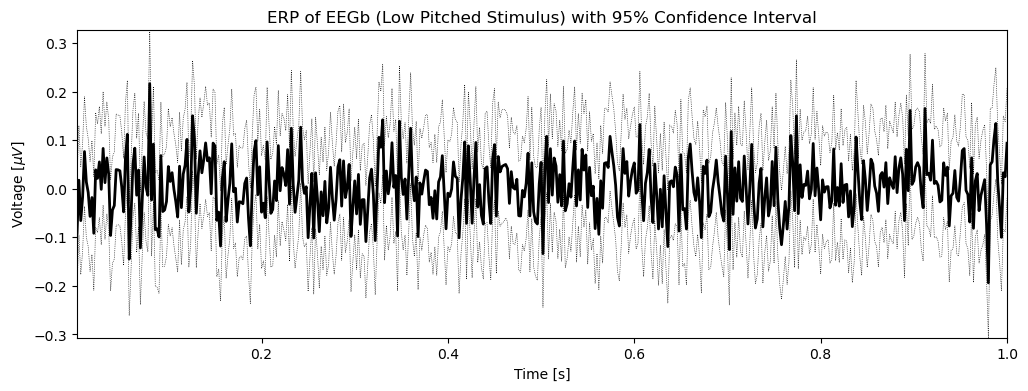

In [43]:
# Compute ERP and confidence intervals for EEGa and EEGb.
ERP_a, conf_ha, conf_la = ERP(EEGa)
ERP_b, conf_hb, conf_lb = ERP(EEGb)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(t, ERP_a, 'k', lw=2)
ax.plot(t, conf_ha, 'k:', lw=0.5)
ax.plot(t, conf_la, 'k:', lw=0.5)
label_plot("ERP of EEGa (High Pitched Stimulus) with 95% Confidence Interval")
fig.savefig("figs/erp/erp_eega_confidence")
fig
plt.show()

fig2, ax2 = plt.subplots(figsize=(12,4))
ax2.plot(t, ERP_b, 'k', lw=2)
ax2.plot(t, conf_hb, 'k:', lw=0.5)
ax2.plot(t, conf_lb, 'k:', lw=0.5)
label_plot("ERP of EEGb (Low Pitched Stimulus) with 95% Confidence Interval")
fig2.savefig("figs/erp/erp_eegb_confidence")
fig2
plt.show()

A relevant question to ask of each trial is: Does the ERP show any real fluctuation from zero? We answer this question by plotting a horizontal line at y = 0 and identifying segments in the graph where zero is not part of the confidence interval. 

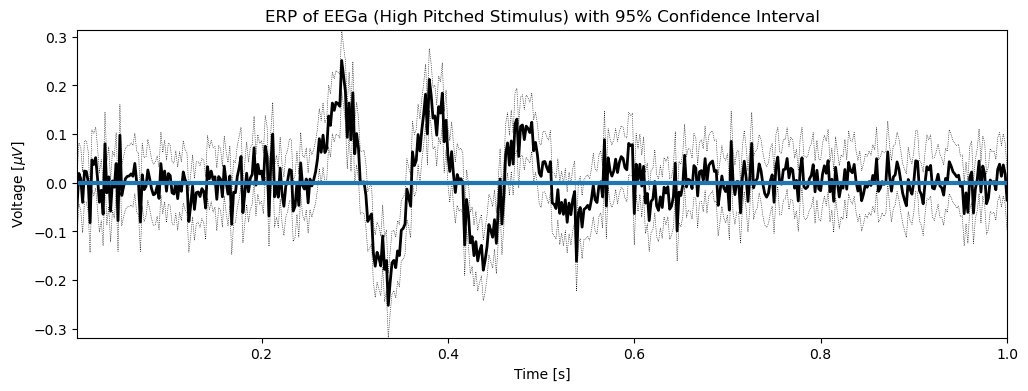

In [44]:
ax.hlines(0, t[0], t[-1], lw=3)
fig.savefig("figs/erp/erp_eega_confidence")
fig

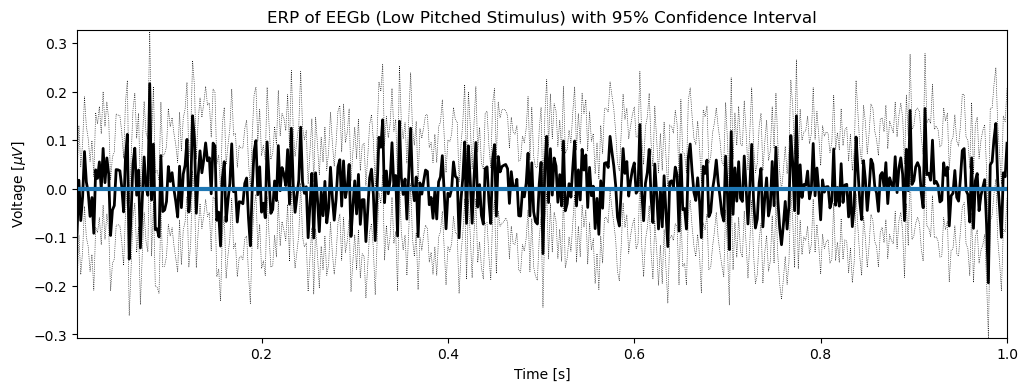

In [45]:
ax2.hlines(0, t[0], t[-1], lw=3)
fig2.savefig("figs/erp/erp_eegb_confidence")
fig2

EEGa's confidence interval does not include 0 at three distinct points, proving that there is a significant effect caused by the high pitched stimulus. EEGb's confidence interval, on the other hand, contains 0 at every point, meaning that there is no observable segment where the results of the low pitched stimulus are significant.

One goal of this experiment is to observe the differences in EEG output between the high pitched stimuli and low pitched stimuli. Lets visualize this difference.

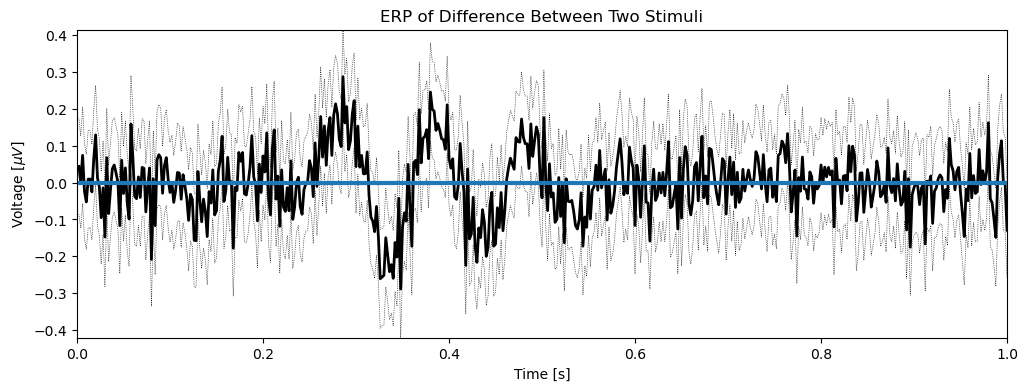

In [46]:
EEG_diff = EEGa - EEGb # Difference between EEGs.
ERP_diff, conf_hdiff, conf_ldiff = ERP(EEG_diff)
plt.plot(t, ERP_diff, 'k', lw=2)
plt.plot(t, conf_hdiff, 'k:', lw=0.5)
plt.plot(t, conf_ldiff, 'k:', lw=0.5)
plt.plot([0, 1], [0, 0], lw=3)
label_plot("ERP of Difference Between Two Stimuli")
plt.savefig("figs/erp/erp_difference")
plt.show()

The visualization of the ERP of the difference between the two EEG datasets shows three instances where there is an observable difference greater than 0 within the confidence interval of the ERP. This shows that the difference between EEG_a and EEG_b is significant at these three points.

The method used throughout the above ERP graphs to find confidence intervals works for the given data, however by virtue of using the Central Limit Theorem (CLT) it leaves room for errors as there are many assumptions in the CLT that may not be true for all datasets. Thus, we use an alternative approach called the **bootstrap** procedure. There are 4 steps to the bootstrap procedure for finding confidence intervals given a dataset of N trials:

1. Sample N trials from the EEG dataset with condition A (with replacement).
2. Average these N trials to create a resampled ERP.
3. Repeat these two steps K times to create a distribution of ERPs. We will use K = 3000.
4. For each timestep, identify the values greater than 2.5% and less than 97.5% of all values in that timestep. This
   range determines the 95% confidence interval for the ERP for that timestep.

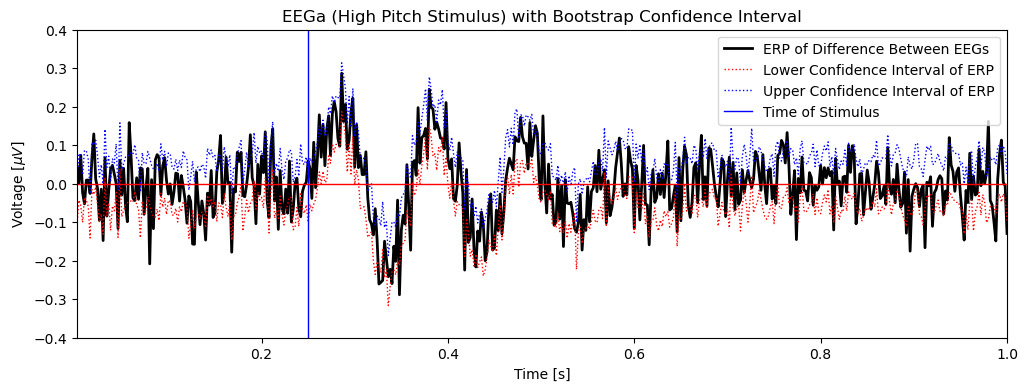

In [58]:
def bootstrapERP(EEGdata, size=None):
    ntrials = len(EEGdata)
    if size == None:
        size = ntrials
    time_idx = np.random.randint(low=0, high=ntrials, size=size) 
    EEG_resamp = EEGdata[time_idx] # Resamples data: Step 1.
    return EEG_resamp.mean(0) # Find ERP of resampled data: Step 2.

all_samp_ERPs = [bootstrapERP(EEGa) for i in range(3000)] # Create distribution of ERPs: Step 3.
all_samp_ERPs = np.array(all_samp_ERPs)
all_samp_ERPs.sort(axis=0) # Sort ERP values of each timestep.
conf_l = all_samp_ERPs[int(0.025 * len(all_samp_ERPs))] # Find lower bound confidence interval.
conf_h = all_samp_ERPs[int(0.975 * len(all_samp_ERPs))] # Find upper bound confidence interval.

plt.plot(t, EEG_diff.mean(axis=0), 'k', lw=2, label="ERP of Difference Between EEGs")
plt.plot(t, conf_l, 'r:', lw=1, label="Lower Confidence Interval of ERP")
plt.plot(t, conf_h, 'b:', lw=1, label="Upper Confidence Interval of ERP")
label_plot("EEGa (High Pitch Stimulus) with Bootstrap Confidence Interval")
plt.plot([0.25, 0.25], [-0.4, 0.4], 'b', lw=1, label="Time of Stimulus")
plt.plot([t[0], t[-1]], [0, 0], 'r', lw=1)
plt.legend()
plt.savefig("figs/erp/boostrap_erp")
plt.show()

Applying this method to the difference between EEGa and EEGb may give us confirmation that there is in fact a significant difference between the two datasets. To do this, it is necessary to quantify this difference. Then the bootstrapping method can be applied to that quantity.

In [59]:
ERP_diff = ERP_a - ERP_b
stat = max(abs(ERP_diff)) # Maximum value of the absolute differences in ERP between EEGa and EEGb
print(stat)

0.28841486379445447


Now that the difference is quanitified, the bootstrapping method can be performed. The null hypothesis for this analysis is that the two datasets have no significant difference. This allows for the ability to sample freely between the two datasets.

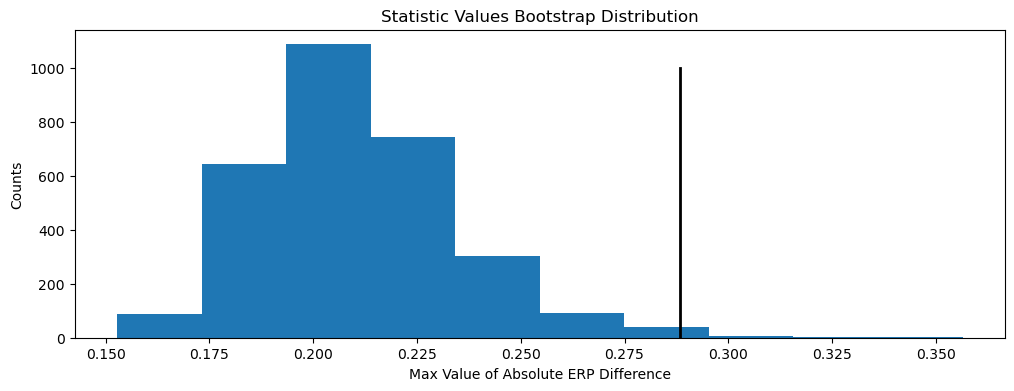

In [63]:
EEG = np.vstack((EEGa, EEGb))                                     

def bootstrapStat(EEG, ntrials):                   
    ERPa = bootstrapERP(EEG, ntrials) 
    ERPb = bootstrapERP(EEG, ntrials)
    ERP_diff = ERPa - ERPb                     
    return max(abs(ERP_diff))                  

stat_diff = [bootstrapStat(EEG, ntrials) for _ in range(3000)]
stat_diff = np.array(stat_diff)
plt.hist(stat_diff)
plt.plot([stat, stat], [0, 1000], 'k', lw=2)
plt.xlabel("Max Value of Absolute ERP Difference")
plt.ylabel("Counts")
plt.title("Statistic Values Bootstrap Distribution")
plt.show()

The final step to test the null hypothesis is to see whether the stat value is greater than 95% of the values in this distribution. 

In [70]:
greater_than = (stat_diff > stat).sum()
percent_greater_than = greater_than / len(stat_diff)
percent_greater_than

0.005

##### The value of stat found from the initial provided datsets is found to be greater than 99.5% of the sampled stat data. Therefore, the null hypothesis is **false**.

#### Conclusion:

There is a significant difference in the EEG response to a high pitched stimuli and a low pitched stimuli.